
___
Machine Learning Based Recommendation Systems

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)
from sklearn.metrics import classification_report
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
import lale
lale.wrap_imported_operators()
import lale.datasets.openml
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat
from lale.lib.lale.hyperopt import Hyperopt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report

In [3]:
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'bank-marketing', 'classification', preprocess=False)
# print last five rows of labels in train_y and features in train_X
bank_data = pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index),
           train_X], axis=1)

train_X.rename(columns={'v1':'age','v2':'job','v3':'marital_status', 'v4':'education','v5':'default','v6':'balance',
                         'v7':'housing','v8':'loan','v9':'contact','v10':'day','v11':'month','v12':'duration',
                          'v13':'campaign','v14':'pdays'  ,'v15':'previous','v16':'poutcome'},inplace=True)

bank_data.rename(columns={'v1':'age','v2':'job','v3':'marital_status', 'v4':'education','v5':'default','v6':'balance',
                         'v7':'housing','v8':'loan','v9':'contact','v10':'day','v11':'month','v12':'duration',
                          'v13':'campaign','v14':'pdays'  ,'v15':'previous','v16':'poutcome'},inplace=True)

bank_data.head()

,y,age,job,marital_status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
6408,0,35.0,technician,divorced,secondary,no,-199.0,yes,no,unknown,27.0,may,137.0,2.0,-1.0,0.0,unknown
29701,0,55.0,unemployed,divorced,primary,no,-53.0,no,no,telephone,3.0,feb,225.0,4.0,6.0,3.0,other
17854,0,44.0,management,married,tertiary,no,4968.0,yes,no,cellular,30.0,jul,76.0,14.0,-1.0,0.0,unknown
1947,0,59.0,blue-collar,married,secondary,no,1376.0,no,yes,unknown,9.0,may,61.0,4.0,-1.0,0.0,unknown
43413,0,50.0,management,married,tertiary,no,5108.0,yes,no,cellular,5.0,apr,874.0,2.0,108.0,3.0,success


In [4]:
bank_data['y'].value_counts()

0    26759
1     3532
Name: y, dtype: int64

In [5]:
bank_data.shape

(30291, 17)

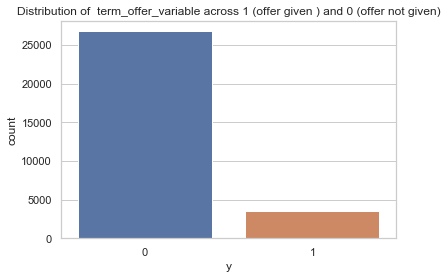

In [6]:
plt.title('Distribution of  term_offer_variable across 1 (offer given ) and 0 (offer not given)')
sns.countplot(x='y',data=bank_data)
plt.show()


# As we see here the dataset is highly imbalaced, so some king of oversampling technique for y=0 needs to be applied

In [7]:
count_no_sub = len(bank_data[bank_data['y']==0])
count_sub = len(bank_data[bank_data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.33977088904294
percentage of subscription 11.66022911095705


In [8]:
bank_data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
0,40.803730,1303.939646,15.882507,219.882133,2.833888,36.580552,0.510146
1,41.612118,1867.015289,15.103624,542.785957,2.143262,66.556908,1.162797


Text(0,0.5,'Frequency of Purchase')

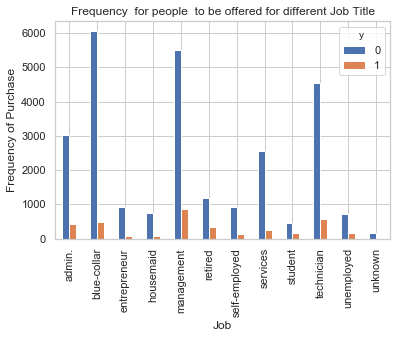

In [9]:
%matplotlib inline
pd.crosstab(bank_data.job,bank_data.y).plot(kind='bar')
plt.title('Frequency  for people  to be offered for different Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')


Text(0,0.5,'Frequency of Purchase')

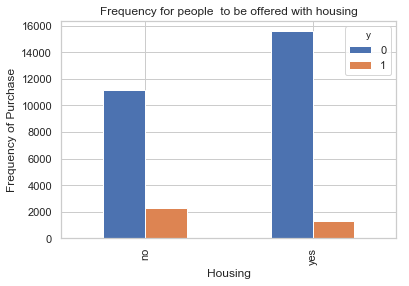

In [10]:
%matplotlib inline
pd.crosstab(bank_data.housing,bank_data.y).plot(kind='bar')
plt.title('Frequency for people  to be offered with housing')
plt.xlabel('Housing')
plt.ylabel('Frequency of Purchase')

Text(0,0.5,'Frequency of Purchase')

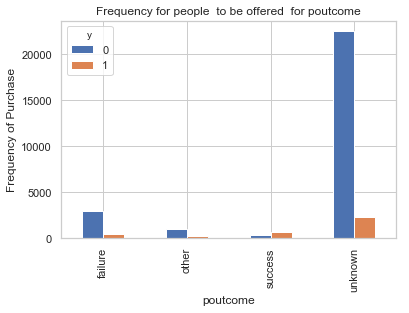

In [11]:
%matplotlib inline
pd.crosstab(bank_data.poutcome,bank_data.y).plot(kind='bar')
plt.title('Frequency for people  to be offered  for poutcome')
plt.xlabel('poutcome')
plt.ylabel('Frequency of Purchase')

In [12]:
train_X.describe()

,age,balance,day,duration,campaign,pdays,previous
count,30291.000000,30291.000000,30291.000000,30291.000000,30291.000000,30291.000000,30291.000000
mean,40.897990,1369.595556,15.791687,257.533459,2.753359,40.075864,0.586247
std,10.599895,3060.624771,8.315021,258.061711,3.080704,100.084915,2.492242
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,452.000000,16.000000,179.000000,2.000000,-1.000000,0.000000
75%,48.000000,1430.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,98417.000000,31.000000,4918.000000,58.000000,871.000000,275.000000


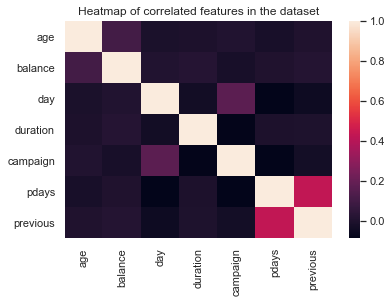

In [13]:
plt.title('Heatmap of correlated features in the dataset')
sns.heatmap(train_X.corr())

In [14]:
def pairwise_corr_rank(df):
    corrs = df.corr().values
    cols = df.columns
    n = corrs.shape[0]
    r,c = np.triu_indices(n,1)
    idx = corrs[r,c].argsort()
    out = np.c_[cols[r[idx]], cols[c[idx]], corrs[r,c][idx]][::-1]
    return pd.DataFrame(out, columns=[['P1','P2','Value']])

# airwise correlation between two variables in the daatset
pairwise_corr_rank(bank_data)

,P1,P2,Value
0,balance,housing,0.42769
1,y,education,0.401595
2,marital_status,default,0.166029
3,age,job,0.105141
4,y,balance,0.0961278
5,y,housing,0.0840484
6,y,job,0.0590467
7,y,age,0.0244769
8,job,education,0.0210854
9,job,housing,0.0167161


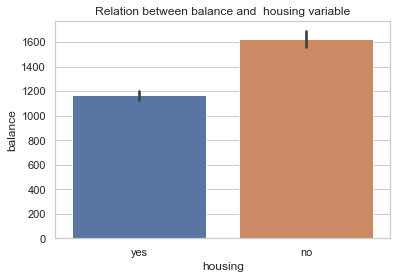

In [15]:
plt.title('Relation between balance and  housing variable')
sns.barplot(y='balance',x='housing', data=bank_data)

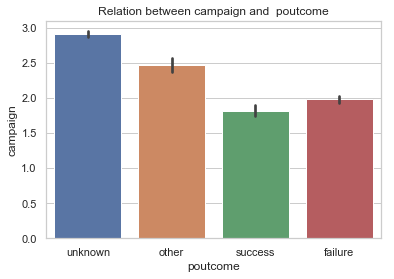

In [16]:
plt.title('Relation between campaign and  poutcome')
sns.barplot(y='campaign',x='poutcome', data=bank_data)

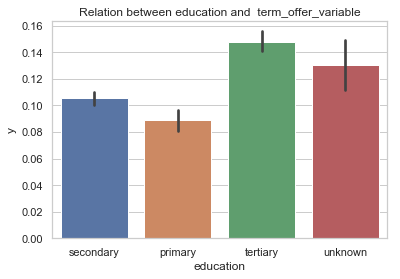

In [17]:
plt.title('Relation between education and  term_offer_variable')
sns.barplot(x='education',y='y', data=bank_data)

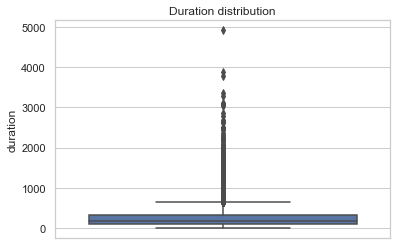

In [18]:
plt.title('Duration distribution')
sns.boxplot(y='duration', data=bank_data)

In [19]:
# Preprocessing dataset

# numerical variables  --> norm
# categorical variable --> one hot encding

#separating columns into num and string
cols = bank_data.columns
num_cols = bank_data._get_numeric_data().columns
string_cols = list(set(cols) - set(num_cols))

bank_data_copy= bank_data.copy()

# normalize numericals columns like age, balance, duration
bank_data[num_cols] = bank_data[num_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


for var in string_cols:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bank_data[var], prefix=var)
    bank=bank_data.join(cat_list, how='left', lsuffix='_left', rsuffix='_right')
    bank_data=bank
    
data_vars=bank_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in string_cols]

bank_data.columns

bank_final=bank_data[to_keep]

# Baseline LR model

Along with accuracy as prediction score, we will use Matthewes coefficient to see the prediction of the model. It takes into account the imbalanced nature of the dataset

#(+1 for the coefficient represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction).

In [20]:
# splitting data for training and testing
X = bank_final.loc[:, bank_final.columns != 'y']
y = bank_final.loc[:, bank_final.columns == 'y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LogisticRegression 
lr_baseline = LogisticRegression(random_state = 0) 
lr_baseline.fit(X_train, y_train) 

/Users/jaspreetkaur/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jaspreetkaur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
import sklearn
y_pred = lr_baseline.predict(X_test)
print('Accuracy of logistic regression classifier  baseline model on test set: {:.2f}'.format(lr_baseline.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of logistic regression classifier  baseline model on test set: 0.90
Matthews correlation coeff 0.4300759992272051


# Sensitivity analysis on the model: PART 1

# Here we take a  specific example and see individual effect on this person by changing some of attribute values on model prediction


In [22]:
row_original = bank_final.loc[[6408]]
row_original

,y,age,balance,day,duration,campaign,pdays,previous,default_no,default_yes,...,education_primary,education_secondary,education_tertiary,education_unknown,loan_no,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
6408,0.0,0.220779,0.073471,0.866667,0.027857,0.017544,0.0,0.0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [23]:
# Now take the encoded data at the same index
row = bank_final.loc[[6408]]
row_X=row.loc[:, row.columns != 'y']
row_X

,age,balance,day,duration,campaign,pdays,previous,default_no,default_yes,contact_cellular,...,education_primary,education_secondary,education_tertiary,education_unknown,loan_no,loan_yes,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
6408,0.220779,0.073471,0.866667,0.027857,0.017544,0.0,0.0,1,0,0,...,0,1,0,0,1,0,0,0,0,1


In [24]:
# now we change the age value and check what the model predicts
row_X['age'] =0.53
y_pred = lr_baseline.predict(row_X)
y_pred
# so we see that if this person's age doesnt change what the model predicts

array([0.])

In [25]:
#similarly if we change the duration to a higher value and check what the model predicts
row = bank_final.loc[[6408]]
row_X=row.loc[:, row.columns != 'y']
row_X['duration'] = 0.8
y_pred = lr_baseline.predict(row_X)
y_pred
# so we see that if this person stays longer with the bank, they would be given the offer

array([1.])

In [26]:
#similarly if we change the balance to a higher value and check what the model predicts
row = bank_final.loc[[6408]]
row_X=row.loc[:, row.columns != 'y']
row_X['balance'] = 0.9
y_pred = lr_baseline.predict(row_X)
y_pred
# so we see that if this person balance increases with the bank, they wouldn't be given the offer still

array([0.])

# Sensitivity analysis on the model : PART 2

Now lets increase some of the values to  positive or negative and see how the model behaves

1. Age of people reduced to half

2. Balance is increased by 10 times

3. duration is increased 400 times


In [27]:
X_test_model = X_test.copy()
X_test_model['age'] = X_test_model['age']*0.5
y_pred = lr_baseline.predict(X_test_model)
print('Accuracy of logistic regression classifier  baseline model on test set: {:.2f}'.format(lr_baseline.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of logistic regression classifier  baseline model on test set: 0.90
Matthews correlation coeff 0.43560986561396375


In [28]:
bank_data_X_test_model = X_test.copy()
X_test_model['balance'] = X_test_model['balance']*10
y_pred = lr_baseline.predict(X_test_model)
print('Accuracy of logistic regression classifier  baseline model on test set: {:.2f}'.format(lr_baseline.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of logistic regression classifier  baseline model on test set: 0.90
Matthews correlation coeff 0.49483871151007597


In [29]:
bank_data_X_test_model = X_test.copy()
X_test_model['duration'] = X_test_model['duration']*400
y_pred = lr_baseline.predict(X_test_model)
print('Accuracy of logistic regression classifier  baseline model on test set: {:.2f}'.format(lr_baseline.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of logistic regression classifier  baseline model on test set: 0.90
Matthews correlation coeff 0.004658455567058302


# Now we will see some individual predicted results to analyse how and why of the model prediction

In [30]:
bank_data_with_prediction = pd.concat([X_test, y_test], axis=1)
bank_data_with_prediction = pd.merge(bank_data_with_prediction, bank_data_copy, left_index=True, right_index=True)


bank_data_with_prediction= bank_data_with_prediction[['y_y', 'age_y',
       'job', 'marital_status', 'education', 'default', 'balance_y', 'housing',
       'loan', 'contact', 'day_y', 'month', 'duration_y', 'campaign_y',
       'pdays_y', 'previous_y', 'poutcome']]
bank_data_with_prediction.rename(columns={'y_y': 'y', 'age_y':'age','balance_y':'balance','day_y':'day',
                                          'pdays_y':'pdays', 'previous_y':'previous','duration_y':'duration',
                                          'campaign_y':'campaign'},inplace=True)

bank_data_with_prediction['prediction'] = y_pred
bank_data_with_prediction = bank_data_with_prediction.reset_index(drop=True)
bank_data_with_prediction.head()

,y,age,job,marital_status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,prediction
0,1,30.0,admin.,single,secondary,no,915.0,yes,no,unknown,27.0,apr,370.0,1.0,-1.0,0.0,unknown,1.0
1,1,30.0,management,single,tertiary,no,3384.0,no,no,cellular,4.0,jun,578.0,2.0,-1.0,0.0,unknown,1.0
2,0,41.0,blue-collar,married,primary,no,389.0,yes,no,unknown,16.0,jun,87.0,6.0,-1.0,0.0,unknown,1.0
3,0,31.0,blue-collar,married,secondary,no,79.0,yes,yes,cellular,23.0,jul,235.0,11.0,-1.0,0.0,unknown,1.0
4,0,28.0,technician,single,tertiary,no,387.0,yes,no,cellular,28.0,jan,455.0,1.0,-1.0,0.0,unknown,1.0


In [31]:
bank_data_with_prediction.groupby('prediction').mean()

,y,age,balance,day,duration,campaign,pdays,previous
prediction,,,,,,,,
0.0,0.00000,53.000000,351.000000,27.000000,0.000000,4.000000,-1.000000,0.000000
1.0,0.11621,40.833443,1390.003136,15.866953,257.807692,2.722351,40.422747,0.597887


In [32]:
bank_data_with_prediction.iloc[450]

y                         0
age                      50
job                  admin.
marital_status      married
education         secondary
default                  no
balance                   0
housing                 yes
loan                    yes
contact             unknown
day                      26
month                   jun
duration                626
campaign                  2
pdays                    -1
previous                  0
poutcome            unknown
prediction                1
Name: 450, dtype: object

In [33]:
# now lets find cases where the the actula an dprediction dont match and see if the model was right or the actual
bank_data_with_prediction.loc[(bank_data_with_prediction['y']==1.0) & (bank_data_with_prediction['prediction'] ==0.0)]


,y,age,job,marital_status,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,prediction


In [34]:
# lets pick any one of the above,
bank_data_with_prediction.iloc[10]

y                        1
age                     59
job                retired
marital_status     married
education          primary
default                 no
balance                363
housing                 no
loan                    no
contact           cellular
day                     30
month                  apr
duration               400
campaign                 1
pdays                   -1
previous                 0
poutcome           unknown
prediction               1
Name: 10, dtype: object

#  LR model with SMOTE for removing the imbalance in the dataset

In [35]:
X = bank_final.loc[:, bank_final.columns != 'y']
y = bank_final.loc[:, bank_final.columns == 'y']
from imblearn.over_sampling import SMOTE

# oversampling since data is imbalanced
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_bank_full_X,os_bank_full_y=os.fit_sample(X_train, y_train)
os_bank_full_X = pd.DataFrame(data=os_bank_full_X,columns=columns )
os_bank_full_y= pd.DataFrame(data=os_bank_full_y,columns=['y'])
# we can Check the numbers of our data
print(os_bank_full_X.shape)



Using TensorFlow backend.


(37418, 51)


In [36]:
bank_data_resampled =pd.concat ([os_bank_full_X,os_bank_full_y], axis=1)
X = bank_data_resampled.loc[:, bank_data_resampled.columns != 'y']
y = bank_data_resampled.loc[:, bank_final.columns == 'y']

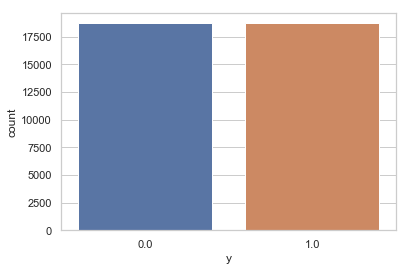

In [37]:
sns.countplot(x='y',data=bank_data_resampled)
plt.show()



In [38]:
# making a separate sets for validation
bank_data_MLX, bank_data_validation_X, bank_data_MLy,bank_data_validation_y=  train_test_split(os_bank_full_X, os_bank_full_y, test_size=0.1, random_state=0)

bank_data_MLX.shape, bank_data_validation_X.shape, bank_data_MLy.shape,bank_data_validation_y.shape

((33676, 51), (3742, 51), (33676, 1), (3742, 1))

In [39]:
# using the datset which is separate from the valuidation set for splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(bank_data_MLX, bank_data_MLy, test_size=0.3, random_state=0)
lr1 = LogisticRegression(C=3,penalty='l2')
lr1.fit(X_train, y_train)

/Users/jaspreetkaur/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jaspreetkaur/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred = lr1.predict(bank_data_validation_X)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(lr1.score(bank_data_validation_X, bank_data_validation_y)))
y_pred = lr1.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr1.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of logistic regression classifier on validation set: 0.90
Accuracy of logistic regression classifier on test set: 0.90
Matthews correlation coeff 0.804706311356772


#So it appears when we logistic regression performs equally well on test and validation dataset, hence an ideal choice 

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      4943
         1.0       0.93      0.87      0.90      5160

    accuracy                           0.90     10103
   macro avg       0.90      0.90      0.90     10103
weighted avg       0.90      0.90      0.90     10103



# Which features are important for this model

In [42]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/jaspreetkaur/.local/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jaspreetkaur/.local/li

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23573, 51), (10103, 51), (23573, 1), (10103, 1))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


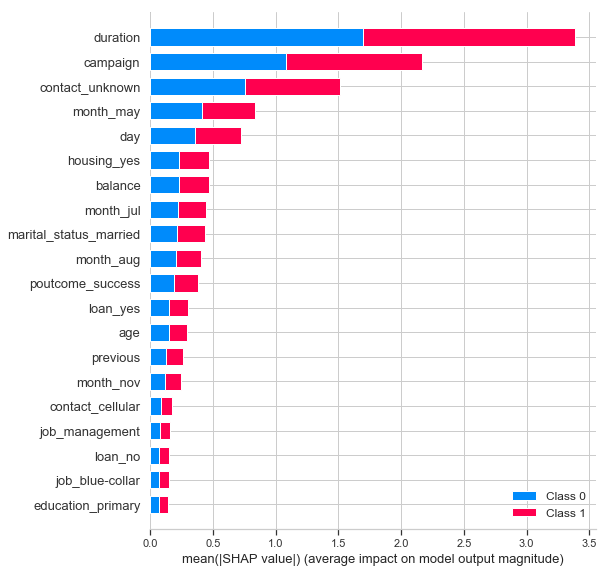

In [44]:
# Also shap explainer to show top 10 features for this model
import shap
explainer = shap.TreeExplainer(clf)
shapX = X_test.sample(10_00)
shap_values = explainer.shap_values(shapX)
shap.summary_plot(shap_values, shapX, plot_type="bar")

# feature3 which is duration is the most important feature, that means the longest the customer has been with us, the more likely they will aceept the marketing offer

In [45]:
# checking the score for tree classifier
y_pred = clf.predict(bank_data_validation_X)
print('Accuracy of Extra tree classifier on validation set: {:.2f}'.format(clf.score(bank_data_validation_X, bank_data_validation_y)))
y_pred = clf.predict(X_test)
print('Accuracy of Extra tree classifier classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')

Accuracy of Extra tree classifier on validation set: 0.94
Accuracy of Extra tree classifier classifier on test set: 0.94
Matthews correlation coeff 0.8774098493657844


# no we do train the model with LALE, since it was difficult to run LALE operators for processed dataset, so the imbalance in the data remains, and I use  sklearn.metrics import matthews_corrcoef coeeficient which will score the dataset for its imbalanced part

LALE is extremely good at the automating the preprocessing part and hyperoptimisation part
which is why I made it part of the project to showcase how easy it is to ease the work of data scientist,
I just hoped it worked with my processed dataset. I am getting Subschema ERROR if I use my processsed dataset

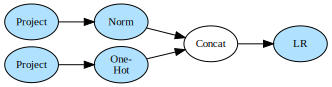

In [46]:
manual_trainable = (
       (  Project(columns={'type': 'number'}) >> Norm()
        & Project(columns={'type': 'string'}) >> OneHot())
    >>Concat
    >> LR())
manual_trainable.visualize()

In [47]:

manual_trained = manual_trainable.fit(train_X, train_y)
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(test_y, manual_y)}')

accuracy 89.4%
Matthews correlation coeff 0.35518735966818615


In [48]:
print(classification_report(test_y,manual_y))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13163
           1       0.62      0.26      0.37      1757

    accuracy                           0.89     14920
   macro avg       0.76      0.62      0.65     14920
weighted avg       0.87      0.89      0.87     14920



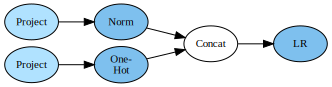

In [49]:
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> (LR ))
auto_planned.visualize()

In [50]:

auto_optimizer = Hyperopt(estimator=auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(test_y, auto_y)}')

100%|██████████| 10/10 [01:13<00:00,  7.36s/trial, best loss: -0.8989798950183223]
accuracy 89.3%
Matthews correlation coeff 0.36923172099077317


In [51]:
# lale predicts the best hyperparameters
auto_trained.get_pipeline().pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={'type': 'number'})
norm = Norm(norm='l1')
project_1 = Project(columns={'type': 'string'})
lr = LR(C=10618.818622619909, multi_class='auto', solver='newton-cg', tol=0.09200172255146725)
pipeline = ((project_0 >> norm) & (project_1 >> OneHot())) >> Concat() >> lr
```

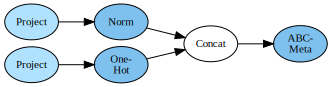

In [52]:
# using decisionTree classifier with lale
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> ( DecisionTreeClassifier))
auto_planned.visualize()

In [53]:

auto_optimizer = Hyperopt(estimator=auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(test_y, auto_y)}')

simplifyAll: '{'default': 'gini'}' has unknown type
simplifyAll: '{'default': 'best'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 2}' has unknown type
simplifyAll: '{'default': 1}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 'deprecated'}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': 'gini'}' has unknown type
simplifyAll: '{'default': 'best'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 2}' has unknown type
simplifyAll: '{'default': 1}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type


100%|██████████| 10/10 [01:06<00:00,  6.68s/trial, best loss: -0.8695322042851013]
accuracy 86.5%
Matthews correlation coeff 0.3643177505674533


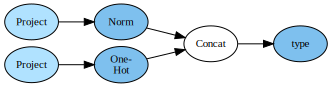

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> ( LinearDiscriminantAnalysis))
auto_planned.visualize()

In [55]:

auto_optimizer = Hyperopt(estimator=auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(test_y, auto_y)}')

simplifyAll: '{'default': 'svd'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': False}' has unknown type
simplifyAll: '{'default': 0.0001}' has unknown type
simplifyAll: '{'default': 'svd'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': False}' has unknown type
simplifyAll: '{'default': 0.0001}' has unknown type


100%|██████████| 10/10 [01:05<00:00,  6.57s/trial, best loss: -0.8941929946188637]
accuracy 88.9%
Matthews correlation coeff 0.33705994199865136


# now seeing which algorithm i selected when combining and letting LALE choose the best one

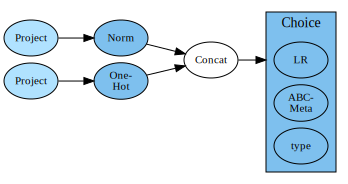

In [56]:
auto_planned = (
       (  Project(columns={'type': 'number'}) >> Norm
        & Project(columns={'type': 'string'}) >> OneHot)
    >> Concat
    >> (LR | DecisionTreeClassifier|LinearDiscriminantAnalysis ))
auto_planned.visualize()

In [57]:
from lale.lib.lale.hyperopt import Hyperopt
auto_optimizer = Hyperopt(estimator=auto_planned, cv=3, max_evals=10)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')
print(f'Matthews correlation coeff {sklearn.metrics.matthews_corrcoef(test_y, auto_y):.1%}')

simplifyAll: '{'default': 'gini'}' has unknown type
simplifyAll: '{'default': 'best'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 2}' has unknown type
simplifyAll: '{'default': 1}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': 'deprecated'}' has unknown type
simplifyAll: '{'default': 0.0}' has unknown type
simplifyAll: '{'default': 'svd'}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': None}' has unknown type
simplifyAll: '{'default': False}' has unknown type
simplifyAll: '{'default': 0.0001}' has unknow

100%|██████████| 10/10 [01:10<00:00,  7.05s/trial, best loss: -0.8998712488858077]
accuracy 89.5%
Matthews correlation coeff 37.3%


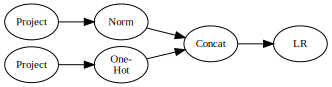

In [58]:
auto_trained.get_pipeline().visualize()

In [59]:
# lale predicts the best hyperparameters
auto_trained.get_pipeline().pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={'type': 'number'})
norm = Norm(norm='max')
project_1 = Project(columns={'type': 'string'})
lr = LR(C=10618.818622619909, multi_class='auto', solver='newton-cg', tol=0.09200172255146725)
pipeline = ((project_0 >> norm) & (project_1 >> OneHot())) >> Concat() >> lr
```

In [60]:
print(classification_report(test_y,auto_y))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13163
           1       0.61      0.29      0.39      1757

    accuracy                           0.89     14920
   macro avg       0.76      0.63      0.67     14920
weighted avg       0.88      0.89      0.88     14920

